#CNN

#### *studi kasus klasifikasi gambar uang*

In [2]:
from google.colab import drive
import os

drive.mount('/content/drive/')

Mounted at /content/drive/


Menyiapkan Direktori

In [3]:
base_dir = '/content/drive/My Drive/uprak_zeri'
!ls "/content/drive/My Drive/uprak_zeri"

bahan  latih  validasi


In [4]:
# menentukan direktori
bahan_dir = os.path.join(base_dir, 'bahan')
train_dir = os.path.join(base_dir, 'latih')
validation_dir = os.path.join(base_dir, 'validasi')

In [5]:
# Direktori isi bahan
seratus_dir = os.path.join(bahan_dir, 'seratus/')
limapuluh_dir = os.path.join(bahan_dir, 'limapuluh/')

print("Banyaknya Data Pada Tiap Kelas")
print('jumlah gambar uang 100.000 :', len(os.listdir(seratus_dir)))
print('jumlah gambar uang 50.000 :', len(os.listdir(limapuluh_dir)))

Banyaknya Data Pada Tiap Kelas
jumlah gambar uang 100.000 : 20
jumlah gambar uang 50.000 : 20


In [6]:
# Direktori isi latih
train_seratus = os.path.join(train_dir, 'seratus/')
train_limapuluh = os.path.join(train_dir, 'limapuluh/')

# Direktori isi validasi
validation_seratus = os.path.join(validation_dir, 'seratus/')
validation_limapuluh = os.path.join(validation_dir, 'limapuluh/')

Menyiapkan Dataset

In [7]:
import random
from shutil import copyfile

def train_val_split(source, train, val, train_ratio):
  total_size = len(os.listdir(source))
  train_size = int(train_ratio * total_size)
  val_size = total_size - train_size

  randomized = random.sample(os.listdir(source), total_size)
  train_files = randomized[0:train_size]
  val_files = randomized[train_size:total_size]

  for i in train_files:
    i_file = source + i
    destination = train + i
    copyfile(i_file, destination)

  for i in val_files:
    i_file = source + i
    destination = val + i
    copyfile(i_file, destination)

# jumlah pembagian data training dan testing
train_ratio = 0.9

# pembagian training dan validasi

# training
source_00 = seratus_dir
train_00 = train_seratus
val_00 = validation_seratus
train_val_split(source_00, train_00, val_00, train_ratio)

# validasi
source_01 = limapuluh_dir
train_01 = train_limapuluh
val_01 = validation_limapuluh
train_val_split(source_01, train_01, val_01, train_ratio)

In [8]:
print('Total seratus :', len(os.listdir(seratus_dir)))
print('Jumlah train seratus :', len(os.listdir(train_seratus)))
print('Jumlah val seratus :', len(os.listdir(validation_seratus)))

Total seratus : 20
Jumlah train seratus : 20
Jumlah val seratus : 14


Pre Processing

In [9]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
train_datagen = ImageDataGenerator(
    rescale =1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.1
)

val_datagen = ImageDataGenerator(
    rescale =1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.1
)

Target

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'categorical'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'categorical'
)

Found 40 images belonging to 2 classes.
Found 29 images belonging to 2 classes.


In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy') > 0.99):
      print('\nAkurasi mencapai 99%')
      self.model.stop_training = True

callbacks = myCallback()

Model Convolutional Neural Network

In [13]:
model = tf.keras.models.Sequential([
# This is the first convolution
tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
tf.keras.layers.MaxPooling2D(2, 2),
# The second convolution
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# The third convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# The fourth convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# # The fifth convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# Flatten the results to feed into a DNN
tf.keras.layers.Flatten(),
# 200 neuron hidden layer
tf.keras.layers.Dense(200, activation='relu'),
tf.keras.layers.Dropout(0.3, seed = 112),
tf.keras.layers.Dense(500, activation='relu'),
tf.keras.layers.Dropout(0.5, seed = 112),

tf.keras.layers.Dense(2, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 5, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 200)                 │          51,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 500)                 │         100,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │           1,002 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 250,342 (977.90 KB)

 Trainable params: 250,342 (977.90 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'Adam',
              metrics=['accuracy'])

Training

In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch= 6,
    epochs= 25,
    validation_data = val_generator,
    validation_steps= 1,
    verbose= 1,
    callbacks = [callbacks]
)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.6333 - loss: 0.6943

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6056 - loss: 0.6993 - val_accuracy: 0.5000 - val_loss: 0.6909
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.4361 - loss: 0.6978 - val_accuracy: 0.3000 - val_loss: 0.6965
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.6431 - loss: 0.6711 - val_accuracy: 0.5556 - val_loss: 0.6522
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.6986 - loss: 0.6343
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.7347 - loss: 0.5594 - val_accuracy: 0.6000 - val_loss: 0.5583
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.8722 - loss: 0.4735 - val_accuracy: 1.0000 - val_loss: 0.2251
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.7250 - loss: 0.7930 - val_accuracy: 0.8889 - val_loss: 0.2324
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.7569 - loss: 0.5403
Epoch 9/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.9611 - loss: 0.3106 - va

Tingkat Akurasi dan Loss Model

ValueError: x and y must have same first dimension, but have shapes (12,) and (9,)

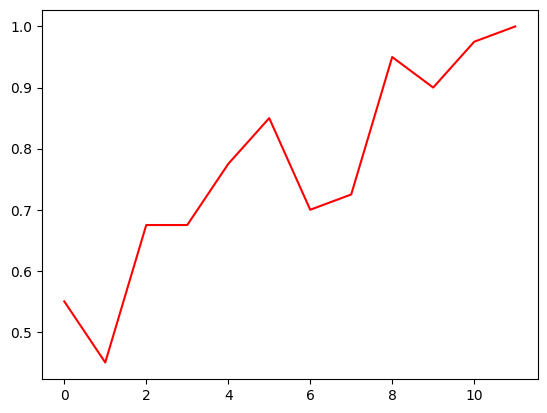

In [21]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.legend(loc = 'best')
plt.show()

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.legend(loc = 'best')
plt.show()

Saving 15.jpg to 15.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
15.jpg
This image belongs to class 100.000


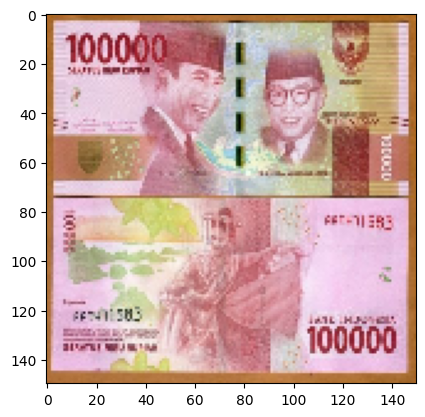

In [23]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  imgplot = plt.imshow(img)

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size= 100)
  classes = np.argmax(classes)

  print(fn)
  if classes==0:
    print('This image belongs to class 50.000')
  elif classes==1:
    print('This image belongs to class 100.000')